# Finance Metrics Demo 
This notebook demonstrates how to fetch financial and economic metrics
for retail demand forecasting.

In [17]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

# Add src to path to import our package
sys.path.insert(0, '../../')

from finance_metrics import * # MarketIndices, CommodityPrices, MacroIndicators, ConsumerMetrics, CustomMetrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
START_DATE = '2023-01-01'
END_DATE = '2025-12-01'

## 1. Market Indices

Market indices reflect economic sentiment and wealth effects that influence
consumer spending behavior.

In [3]:
market = MarketIndices()

# Fetch S&P 500 data for the last year
sp500 = market.get_index("sp500", start_date=START_DATE, end_date=END_DATE)
print("S&P 500 Data:")
print(sp500.head())
print(f"\nShape: {sp500.shape}")

S&P 500 Data:
Price             Close         High          Low         Open      Volume
Date                                                                      
2023-01-03  3824.139893  3878.459961  3794.330078  3853.290039  3959140000
2023-01-04  3852.969971  3873.159912  3815.770020  3840.360107  4414080000
2023-01-05  3808.100098  3839.739990  3802.419922  3839.739990  3893450000
2023-01-06  3895.080078  3906.189941  3809.560059  3823.370117  3923560000
2023-01-09  3892.090088  3950.570068  3890.419922  3910.820068  4311770000

Shape: (730, 5)


## 2. Data Aggregation for Weekly Forecasting

Example of how to aggregate daily data to weekly intervals for alignment with your forecasting model.

In [4]:
# Aggregate daily market data to weekly
daily_sp500 = market.get_index("sp500", start_date=START_DATE, end_date=END_DATE)

# Resample to weekly frequency (Sunday as end of week)
# Apply aggregation to entire DataFrame, not just 'Close' series
weekly_agg = daily_sp500.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("Weekly Aggregated Data:")
display(weekly_agg.head(10))

# Calculate weekly features for forecasting
weekly_features = pd.DataFrame({
    'close': weekly_agg['Close'],
    'weekly_return': weekly_agg['Close'].pct_change(),
    'volatility': daily_sp500['Close'].resample('W').std(),
    'avg_volume': daily_sp500['Volume'].resample('W').mean()
})

print("\nWeekly Features for Forecasting:")
display(weekly_features.head())

Weekly Aggregated Data:


Price,Open,High,Low,Close,Volume
Date,,,,,
2023-01-08,3853.290039,3906.189941,3794.330078,3895.080078,16190230000
2023-01-15,3910.820068,4003.949951,3877.290039,3999.090088,20846120000
2023-01-22,3999.280029,4015.389893,3885.540039,3972.610107,16539130000
2023-01-29,3978.139893,4094.209961,3949.060059,4070.560059,18707010000
2023-02-05,4049.270020,4195.439941,4015.550049,4136.479980,23657120000
2023-02-12,4119.569824,4176.540039,4060.790039,4090.459961,20661640000
2023-02-19,4096.620117,4159.770020,4047.949951,4079.090088,19642940000
2023-02-26,4052.350098,4052.350098,3943.080078,3970.040039,16031550000
2023-03-05,3992.360107,4048.290039,3928.159912,4045.639893,21459460000



Weekly Features for Forecasting:


,close,weekly_return,volatility,avg_volume
Date,,,,
2023-01-08,3895.080078,NaN,38.158706,4.047558e+09
2023-01-15,3999.090088,0.026703,45.163191,4.169224e+09
2023-01-22,3972.610107,-0.006622,41.769200,4.134782e+09
2023-01-29,4070.560059,0.024656,26.477987,3.741402e+09
2023-02-05,4136.479980,0.016194,61.629767,4.731424e+09


## 2. Commodity Prices

Commodity prices (especially energy) affect consumer costs and purchasing power.

In [5]:
commodities = CommodityPrices()

# Get oil spread (WTI vs Brent)
oil_spread = commodities.get_oil_spread(start_date=START_DATE, end_date=END_DATE)
print("\nOil Spread (Brent - WTI):")
display(oil_spread.head())
print(f"\nAverage Spread: ${oil_spread['spread'].mean():.2f}")

# Fetch WTI crude oil prices
oil = commodities.get_commodity("crude_oil_wti", start_date=START_DATE, end_date=END_DATE)
print("WTI Crude Oil Prices:")
display(oil.head())
print(f"\nAverage Price: ${oil['Close'].mean():.2f}")
print(f"Price Range: ${oil['Close'].min():.2f} - ${oil['Close'].max():.2f}")


Oil Spread (Brent - WTI):


,wti,brent,spread
Date,,,
2023-01-03,76.930000,82.099998,5.169998
2023-01-04,72.839996,77.839996,5.000000
2023-01-05,73.669998,78.690002,5.020004
2023-01-06,73.769997,78.570000,4.800003
2023-01-09,74.629997,79.650002,5.020004



Average Spread: $4.01
WTI Crude Oil Prices:


Price,Close,High,Low,Open,Volume
Date,,,,,
2023-01-03,76.930000,81.500000,76.599998,80.570000,338520
2023-01-04,72.839996,77.419998,72.730003,77.250000,352434
2023-01-05,73.669998,74.919998,72.459999,73.250000,300731
2023-01-06,73.769997,75.470001,73.239998,73.970001,258128
2023-01-09,74.629997,76.739998,73.470001,73.470001,329290



Average Price: $73.19
Price Range: $57.13 - $93.68


In [6]:
# Calculate weekly returns (aligned with weekly forecasting)
weekly_sp500 = market.get_index("sp500", start_date=START_DATE, interval="1wk")
weekly_returns = weekly_sp500['Close'].pct_change()
print("\nWeekly Returns (for alignment with weekly forecasts):")
print(weekly_returns.head(10))
print(f"\nMean Weekly Return: {weekly_returns.mean():.4f}")
print(f"Std Dev: {weekly_returns.std():.4f}")


Weekly Returns (for alignment with weekly forecasts):
Date
2023-01-01         NaN
2023-01-08    0.026703
2023-01-15   -0.006622
2023-01-22    0.024656
2023-01-29    0.016194
2023-02-05   -0.011125
2023-02-12   -0.002780
2023-02-19   -0.026734
2023-02-26    0.019043
2023-03-05   -0.045493
Name: Close, dtype: float64

Mean Weekly Return: 0.0039
Std Dev: 0.0202


In [7]:
# Fetch multiple indices at once for comparison
indices = market.get_multiple_indices(
    ["sp500", "nasdaq", "vix"],
    start_date=START_DATE,
    end_date=END_DATE
)
print("\nMultiple Indices:")
print(indices.head())
print(f"\nCorrelation Matrix:")
print(indices.corr())


Multiple Indices:
                  sp500        nasdaq        vix
Date                                            
2023-01-03  3824.139893  10386.980469  22.900000
2023-01-04  3852.969971  10458.759766  22.010000
2023-01-05  3808.100098  10305.240234  22.459999
2023-01-06  3895.080078  10569.290039  21.129999
2023-01-09  3892.090088  10635.650391  21.969999

Correlation Matrix:
           sp500    nasdaq       vix
sp500   1.000000  0.995327  0.003449
nasdaq  0.995327  1.000000 -0.033290
vix     0.003449 -0.033290  1.000000


## 3. Macroeconomic Indicators (FRED API)

Macroeconomic indicators provide context for overall economic health and consumer purchasing power.

In [8]:
# Initialize MacroIndicators (will load FRED_API_KEY from .env)
macro = MacroIndicators()

# Fetch unemployment rate
unemployment = macro.get_unemployment_rate(start_date="2020-01-01", end_date=END_DATE)
print("Unemployment Rate:")
display(unemployment.tail())
print(f"\nCurrent Unemployment Rate: {unemployment.iloc[-1].values[0]:.2f}%")

Unemployment Rate:


,UNRATE
2025-05-01,4.2
2025-06-01,4.1
2025-07-01,4.2
2025-08-01,4.3
2025-09-01,4.4



Current Unemployment Rate: 4.40%


In [9]:
# Fetch multiple macro indicators at once
macro_indicators = macro.get_multiple_indicators(
    ["unemployment", "fed_funds", "cpi"],
    start_date=START_DATE,
    end_date=END_DATE
)

print("Multiple Macro Indicators:")
display(macro_indicators.head(10))
print("\nCorrelation Matrix:")
display(macro_indicators.corr())

Multiple Macro Indicators:


,UNRATE,FEDFUNDS,CPIAUCSL
2023-01-01,3.5,4.33,300.456
2023-02-01,3.6,4.57,301.476
2023-03-01,3.5,4.65,301.643
2023-04-01,3.4,4.83,302.858
2023-05-01,3.6,5.06,303.316
2023-06-01,3.6,5.08,304.099
2023-07-01,3.5,5.12,304.615
2023-08-01,3.7,5.33,306.138
2023-09-01,3.8,5.33,307.374
2023-10-01,3.9,5.33,307.653



Correlation Matrix:


,UNRATE,FEDFUNDS,CPIAUCSL
UNRATE,1.000000,-0.339096,0.929061
FEDFUNDS,-0.339096,1.000000,-0.498332
CPIAUCSL,0.929061,-0.498332,1.000000


In [10]:
# Fetch CPI and calculate inflation rate
cpi = macro.get_cpi(start_date="2020-01-01", end_date=END_DATE)
inflation = macro.get_inflation_rate(start_date="2020-01-01", end_date=END_DATE)

print("CPI (Consumer Price Index):")
display(cpi.tail())
print("\nYear-over-Year Inflation Rate:")
display(inflation.tail())
print(f"\nLatest Inflation Rate: {inflation['inflation_rate'].iloc[-1]:.2f}%")

CPI (Consumer Price Index):


,CPIAUCSL
2025-05-01,320.580
2025-06-01,321.500
2025-07-01,322.132
2025-08-01,323.364
2025-09-01,324.368



Year-over-Year Inflation Rate:


,inflation_rate
2025-05-01,2.375934
2025-06-01,2.672683
2025-07-01,2.731801
2025-08-01,2.939220
2025-09-01,3.022700



Latest Inflation Rate: 3.02%


## 4. Consumer Metrics (FRED API)

Consumer-focused metrics that directly relate to retail spending behavior.

In [18]:
# Initialize ConsumerMetrics
consumer = ConsumerMetrics()

# Fetch consumer sentiment
sentiment = consumer.get_consumer_sentiment(start_date="2020-01-01", end_date=END_DATE)
print("Consumer Sentiment (University of Michigan):")
display(sentiment.tail())
print(f"\nLatest Consumer Sentiment: {sentiment.iloc[-1].values[0]:.2f}")

Consumer Sentiment (University of Michigan):


,UMCSENT
2025-06-01,60.7
2025-07-01,61.7
2025-08-01,58.2
2025-09-01,55.1
2025-10-01,53.6



Latest Consumer Sentiment: 53.60


In [12]:
# Fetch retail sales and calculate growth rate
retail_sales = consumer.get_retail_sales(start_date="2020-01-01", end_date=END_DATE)
retail_growth = consumer.get_retail_sales_growth(start_date="2020-01-01", end_date=END_DATE)

print("Retail Sales (excluding food services):")
display(retail_sales.tail())
print("\nYear-over-Year Retail Sales Growth:")
display(retail_growth.tail())
print(f"\nLatest Growth Rate: {retail_growth['retail_sales_growth'].iloc[-1]:.2f}%")

Retail Sales (excluding food services):


,RSXFS
2025-05-01,618037.0
2025-06-01,624146.0
2025-07-01,628747.0
2025-08-01,632082.0
2025-09-01,632541.0



Year-over-Year Retail Sales Growth:


,retail_sales_growth
2025-05-01,2.942342
2025-06-01,4.027974
2025-07-01,3.785485
2025-08-01,4.718514
2025-09-01,3.881381



Latest Growth Rate: 3.88%


In [13]:
# Fetch multiple consumer metrics
consumer_metrics = consumer.get_multiple_metrics(
    ["consumer_sentiment", "retail_sales", "personal_saving_rate"],
    start_date=START_DATE,
    end_date=END_DATE
)

print("Multiple Consumer Metrics:")
display(consumer_metrics.head(10))

Multiple Consumer Metrics:


,UMCSENT,RSXFS,PSAVERT
2023-01-01,64.9,591964.0,4.9
2023-02-01,66.9,586165.0,5.5
2023-03-01,62.0,578812.0,6.0
2023-04-01,63.7,583874.0,5.8
2023-05-01,59.0,586286.0,6.1
2023-06-01,64.2,588670.0,5.8
2023-07-01,71.5,589257.0,5.5
2023-08-01,69.4,595191.0,5.6
2023-09-01,67.8,598956.0,5.3
2023-10-01,63.8,595517.0,5.4


## 5. Aligning Mixed Frequencies for Weekly Forecasting

Economic data comes at different frequencies (daily, weekly, monthly, quarterly). Here's how to align them for weekly forecasting.

In [14]:
# Combine data from different sources and frequencies

# Daily data from yfinance - fetch daily then resample to weekly
# Note: For futures contracts, always fetch daily data first, then resample
# Direct weekly requests often fail due to contract rollovers
sp500_daily = market.get_index("sp500", start_date=START_DATE, end_date=END_DATE)
sp500_weekly = sp500_daily['Close'].resample('W').last()

oil_daily = commodities.get_commodity("crude_oil_wti", start_date=START_DATE, end_date=END_DATE)
oil_weekly = oil_daily['Close'].resample('W').last()

# Monthly data: Consumer metrics and macro indicators
cpi_monthly = macro.get_cpi(start_date=START_DATE, end_date=END_DATE)
sentiment_monthly = consumer.get_consumer_sentiment(start_date=START_DATE, end_date=END_DATE)

# Forward-fill monthly data to weekly frequency
cpi_weekly = cpi_monthly.resample('W').ffill()
sentiment_weekly = sentiment_monthly.resample('W').ffill()

# Combine all features
combined_features = pd.DataFrame({
    'sp500_close': sp500_weekly,
    'oil_price': oil_weekly,
    'cpi': cpi_weekly.iloc[:, 0],
    'consumer_sentiment': sentiment_weekly.iloc[:, 0]
})

print("Combined Weekly Features for Forecasting:")
display(combined_features.head(10))
print(f"\nShape: {combined_features.shape}")
print("\nMissing values:")
print(combined_features.isna().sum())

Combined Weekly Features for Forecasting:


,sp500_close,oil_price,cpi,consumer_sentiment
2023-01-01,NaN,NaN,300.456,64.9
2023-01-08,3895.080078,73.769997,300.456,64.9
2023-01-15,3999.090088,79.860001,300.456,64.9
2023-01-22,3972.610107,81.309998,300.456,64.9
2023-01-29,4070.560059,79.680000,300.456,64.9
2023-02-05,4136.479980,73.389999,301.476,66.9
2023-02-12,4090.459961,79.720001,301.476,66.9
2023-02-19,4079.090088,76.339996,301.476,66.9
2023-02-26,3970.040039,76.320000,301.476,66.9
2023-03-05,4045.639893,79.680000,301.643,62.0



Shape: (153, 4)

Missing values:
sp500_close            1
oil_price              1
cpi                   12
consumer_sentiment     8
dtype: int64


## 6. Custom Metrics - MeiTou QQQ 200 Days Deviation Index

The MeiTou QQQ Deviation Index measures how far QQQ (Nasdaq-100 ETF) is trading from its 200-day moving average, providing insight into market momentum and potential turning points.

In [60]:
CUSTOM_START_DATE = "2015-01-01"

# Initialize CustomMetrics
custom = CustomMetrics()

# Calculate MeiTou QQQ Deviation Index
# Note: Need data before start date for 200-day SMA calculation
qqq_deviation = custom.get_meitou_qqq_deviation(
    start_date=CUSTOM_START_DATE,  # Extra data for SMA warmup
    end_date=END_DATE
)

print("MeiTou QQQ 200 Days Deviation Index:")
display(qqq_deviation.tail(10))

# Show current status
current_dev = qqq_deviation['Deviation'].iloc[-1]
current_signal = qqq_deviation['Signal'].iloc[-1]
print(f"\nCurrent Deviation: {current_dev:.2%}")
print(f"Current Signal: {current_signal}")

MeiTou QQQ 200 Days Deviation Index:


Price,Close,SMA_200,Deviation,Signal
Date,,,,
2025-11-14,608.859985,540.839060,0.125769,Strong Bullish
2025-11-17,603.659973,541.255739,0.115295,Strong Bullish
2025-11-18,596.309998,541.656491,0.100901,Strong Bullish
2025-11-19,599.869995,542.043362,0.106683,Strong Bullish
2025-11-20,585.669983,542.347377,0.079880,Strong Bullish
2025-11-21,590.070007,542.659694,0.087367,Strong Bullish
2025-11-24,605.159973,543.080736,0.114309,Strong Bullish
2025-11-25,608.890015,543.488897,0.120336,Strong Bullish
2025-11-26,614.270020,543.930234,0.129318,Strong Bullish



Current Deviation: 13.75%
Current Signal: Strong Bullish


In [61]:
# Get statistical summary
stats = custom.get_deviation_stats(start_date=CUSTOM_START_DATE, end_date=END_DATE)

print("Statistical Summary of QQQ Deviation Index:")
print(f"Mean Deviation: {stats['mean_deviation']:.2%}")
print(f"Median Deviation: {stats['median_deviation']:.2%}")
print(f"Std Deviation: {stats['std_deviation']:.2%}")
print(f"Min Deviation: {stats['min_deviation']:.2%}")
print(f"Max Deviation: {stats['max_deviation']:.2%}")
print(f"% Time Bullish: {stats['pct_bullish']:.1f}%")
print(f"% Time Bearish: {stats['pct_bearish']:.1f}%")

Statistical Summary of QQQ Deviation Index:
Mean Deviation: 7.17%
Median Deviation: 8.80%
Std Deviation: 8.85%
Min Deviation: -23.71%
Max Deviation: 33.08%
% Time Bullish: 81.8%
% Time Bearish: 18.2%


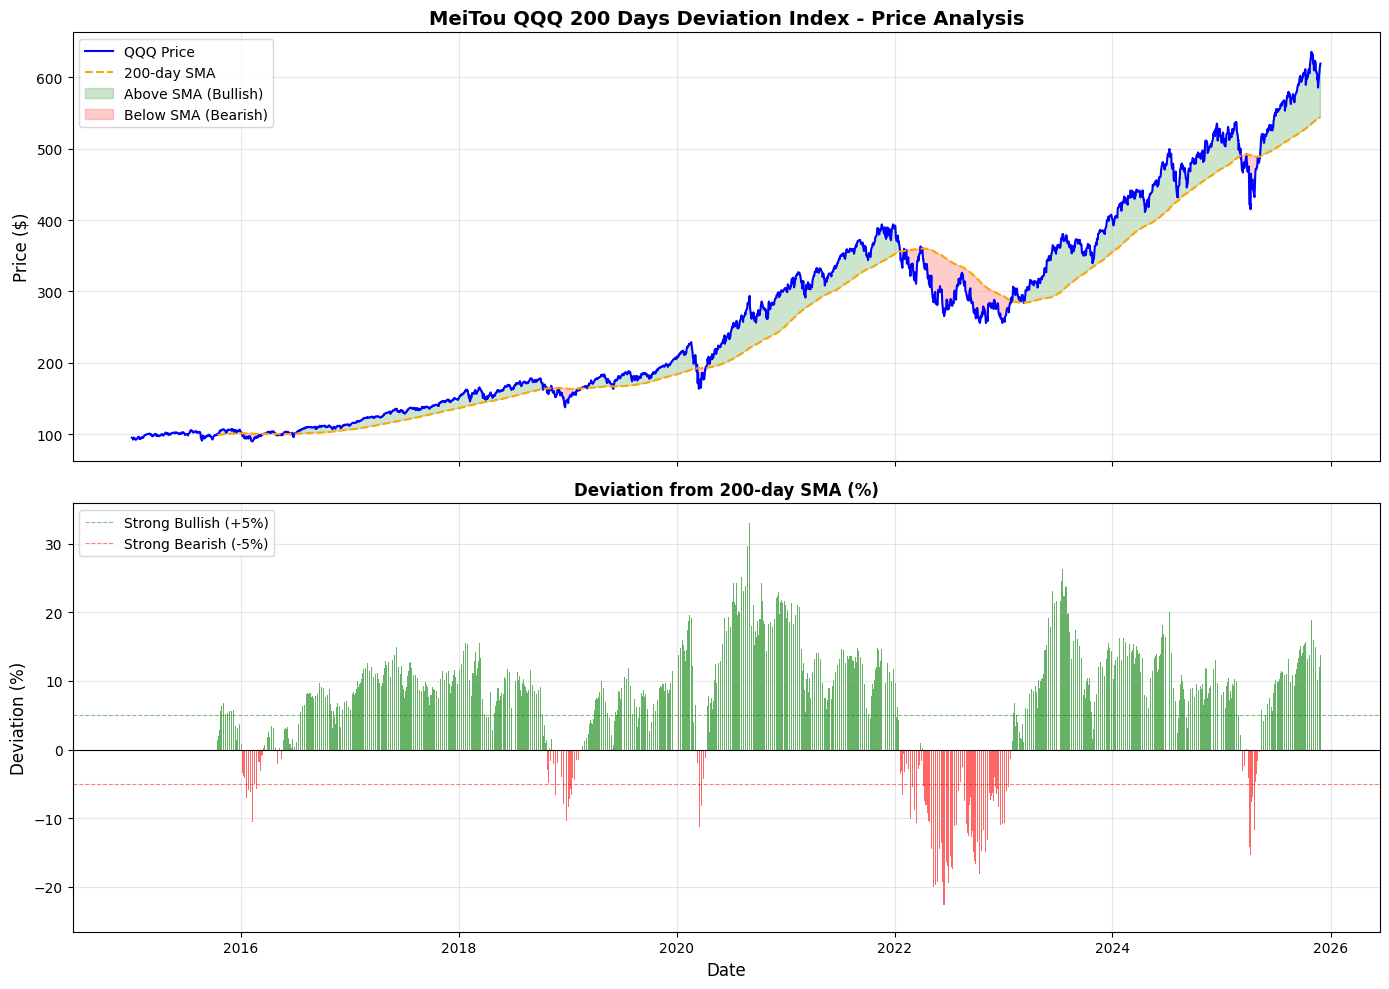


Current Status: QQQ is 13.75% ABOVE its 200-day SMA


In [62]:
# Visualization 1: QQQ Price vs 200-day SMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Price and SMA
ax1.plot(qqq_deviation.index, qqq_deviation['Close'], label='QQQ Price', linewidth=1.5, color='blue')
ax1.plot(qqq_deviation.index, qqq_deviation['SMA_200'], label='200-day SMA', linewidth=1.5, color='orange', linestyle='--')
ax1.fill_between(qqq_deviation.index, 
                  qqq_deviation['Close'], 
                  qqq_deviation['SMA_200'],
                  where=(qqq_deviation['Close'] >= qqq_deviation['SMA_200']),
                  alpha=0.2, color='green', label='Above SMA (Bullish)')
ax1.fill_between(qqq_deviation.index, 
                  qqq_deviation['Close'], 
                  qqq_deviation['SMA_200'],
                  where=(qqq_deviation['Close'] < qqq_deviation['SMA_200']),
                  alpha=0.2, color='red', label='Below SMA (Bearish)')
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('MeiTou QQQ 200 Days Deviation Index - Price Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom panel: Deviation percentage
colors = ['green' if x > 0 else 'red' for x in qqq_deviation['Deviation']]
ax2.bar(qqq_deviation.index, qqq_deviation['Deviation'] * 100, color=colors, alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(y=5, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bullish (+5%)')
ax2.axhline(y=-5, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bearish (-5%)')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Deviation (%)', fontsize=12)
ax2.set_title('Deviation from 200-day SMA (%)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCurrent Status: QQQ is {abs(current_dev):.2%} {'ABOVE' if current_dev > 0 else 'BELOW'} its 200-day SMA")

/var/folders/x4/dyk31hkd1850s3dyrqpd48100000gn/T/ipykernel_94134/3721228028.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(signal_data, labels=signal_labels)


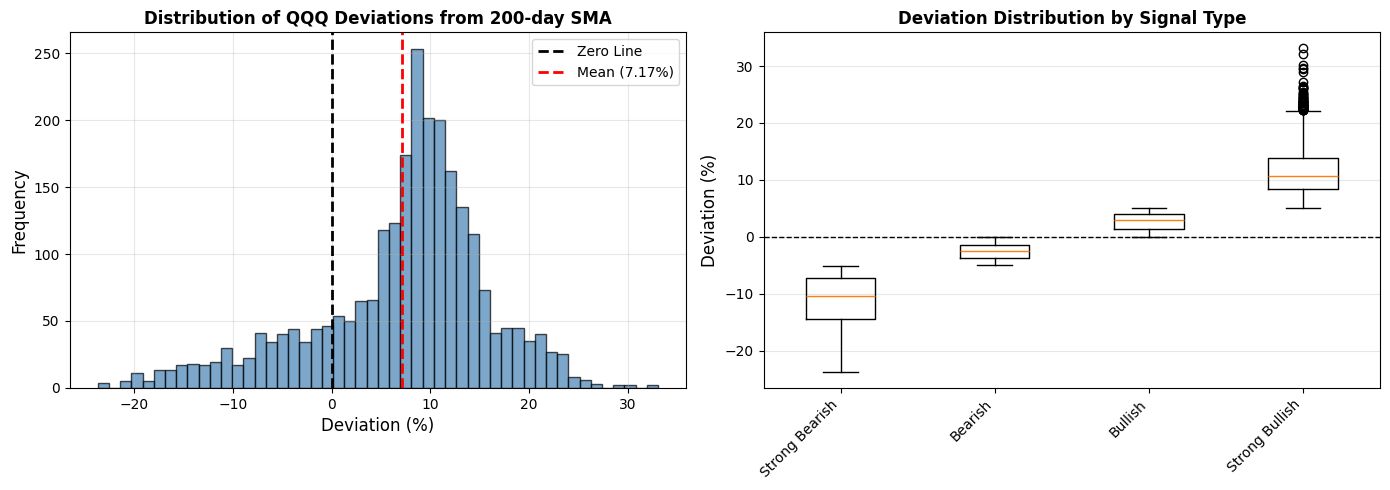

In [63]:
# Visualization 2: Distribution of Deviations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
valid_deviations = qqq_deviation['Deviation'].dropna() * 100
ax1.hist(valid_deviations, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Line')
ax1.axvline(x=valid_deviations.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean ({valid_deviations.mean():.2f}%)')
ax1.set_xlabel('Deviation (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of QQQ Deviations from 200-day SMA', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot by signal type
signal_data = []
signal_labels = []
for signal in ['Strong Bearish', 'Bearish', 'Bullish', 'Strong Bullish']:
    mask = qqq_deviation['Signal'] == signal
    if mask.sum() > 0:
        signal_data.append(qqq_deviation.loc[mask, 'Deviation'].dropna() * 100)
        signal_labels.append(signal)

ax2.boxplot(signal_data, labels=signal_labels)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Deviation (%)', fontsize=12)
ax2.set_title('Deviation Distribution by Signal Type', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Weekly MeiTou QQQ Deviation Index:


Price,Close,SMA_200,Deviation,Signal
Date,,,,
2025-09-28,595.969971,524.494909,0.136274,Strong Bullish
2025-10-05,603.179993,526.472146,0.145702,Strong Bullish
2025-10-12,589.500000,528.545504,0.115325,Strong Bullish
2025-10-19,603.929993,530.522575,0.138368,Strong Bullish
2025-10-26,617.099976,532.952777,0.157889,Strong Bullish
2025-11-02,629.070007,536.011266,0.173613,Strong Bullish
2025-11-09,609.739990,538.421898,0.132458,Strong Bullish
2025-11-16,608.859985,540.839060,0.125769,Strong Bullish
2025-11-23,590.070007,542.659694,0.087367,Strong Bullish


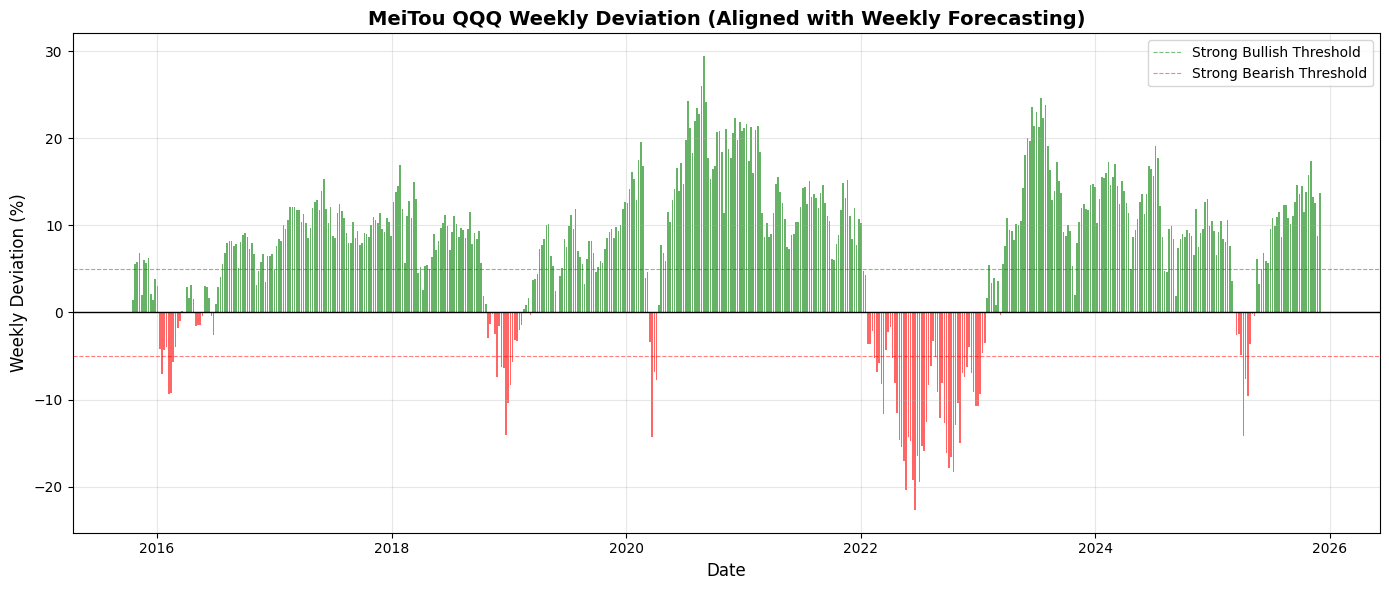


Weekly deviation can be used as a feature for item-level weekly demand forecasting


In [64]:
# Weekly aggregation for forecasting alignment
qqq_weekly = custom.get_meitou_qqq_deviation_weekly(
    start_date=CUSTOM_START_DATE,
    end_date=END_DATE
)

print("Weekly MeiTou QQQ Deviation Index:")
display(qqq_weekly.tail(10))

# Visualize weekly deviation
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['green' if x > 0 else 'red' for x in qqq_weekly['Deviation']]
ax.bar(qqq_weekly.index, qqq_weekly['Deviation'] * 100, color=colors, alpha=0.6, width=5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=5, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bullish Threshold')
ax.axhline(y=-5, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong Bearish Threshold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Weekly Deviation (%)', fontsize=12)
ax.set_title('MeiTou QQQ Weekly Deviation (Aligned with Weekly Forecasting)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nWeekly deviation can be used as a feature for item-level weekly demand forecasting")

### Interpretation of MeiTou QQQ Deviation Index

**Signal Meanings:**
- **Strong Bullish** (>+5%): QQQ is significantly above its 200-day trend → Strong positive momentum, possible overextension
- **Bullish** (0% to +5%): QQQ is moderately above trend → Positive momentum
- **Bearish** (-5% to 0%): QQQ is moderately below trend → Negative momentum
- **Strong Bearish** (<-5%): QQQ is significantly below its 200-day trend → Strong negative momentum, possible oversold

**Use for Retail Forecasting:**
- Tech sector momentum (Nasdaq-100) influences consumer confidence and spending
- Extreme deviations (±5% or more) may signal economic turning points
- Weekly deviation values can be used as a feature in demand forecasting models
- Correlate with retail categories (e.g., electronics, luxury goods) sensitive to market sentiment

## Summary

This library provides access to:

**Fully Implemented:**
- **Market Indices**: S&P 500, Dow, NASDAQ, VIX (via yfinance)
- **Commodity Prices**: Oil, gas, gold, agricultural products (via yfinance)
- **Macroeconomic Indicators**: GDP, CPI, unemployment, interest rates (via FRED)
- **Consumer Metrics**: Consumer sentiment, retail sales, PCE, disposable income (via FRED)
- **Custom Metrics**: MeiTou QQQ 200 Days Deviation Index

**Key Features for Retail Forecasting:**
- Weekly data aggregation from multiple frequencies
- Year-over-year growth calculations
- Easy access to economic indicators that influence consumer behavior
- Custom technical indicators like QQQ deviation for market sentiment
- Correlation analysis between economic conditions and retail demand

**Next Development Steps:**
- Add more custom metrics as needed
- Add feature engineering utilities (lagged features, rolling windows)
- Implement data caching for faster repeated queries
- Add data quality checks and outlier detection
- Build correlation analysis tools between metrics and retail demand